# Virtual moorings from ROMS data

This notebook shows the basics of extracting time series at locations (i.e. virtual moorings). This will use the Shackleton ROMS model (D. Gwyther) as the data source and will produce time series that are potentially useful for the Denman voyage (2025).

**Requirements:** This notebook will require the ROMS output. 

First, we load any required modules. The following are pretty standard:

In [1]:
# import intake
import numpy as np

import xarray as xr
# import cf_xarray as cfxr
from xgcm import Grid
from pyproj import Transformer
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.pyplot as plt

from dask.distributed import Client

These modules are more optional:

In [2]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps
import cartopy.feature as cft                     # For adding features to maps

It's often a good idea to start a cluster with multiple cores for you to work with. This is the easiest way to do that:

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 47.05 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41307,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 47.05 GiB
Comm: tcp://127.0.0.1:37763,Total threads: 4
Dashboard: http://127.0.0.1:36209/status,Memory: 9.41 GiB
Nanny: tcp://127.0.0.1:40419,


You will need to nominate a catalog from which to load your data. Unless there is a pressing need, it is best to use the default catalog:

In [4]:
# catalog = intake.cat.access_nri

Start by loading the ROMS output.

In [5]:
# simple method for loading his files - replace with intake catalog method.and
import glob
FilePath='../../shackleton-setup/notebooks/' # Truth file settings
prefix='roms_his_'

filelist = glob.glob(FilePath+prefix+'*.nc')
ds = xr.open_mfdataset(filelist,{'ocean_time':1}, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right')

Prepare the ROMS dataset for use.

In [6]:
# do special processing for ROMS formatting

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    grid = Grid(ds,
                coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
                'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
                'Z':{'center':'s_rho', 'outer':'s_w'}},
                periodic=[])

    

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta+ds.zice + (ds.zeta+ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta+ds.zice + ds.h) + ds.zeta + ds.zice

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds



def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut


ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a se

Make some other masks that we might need.

In [7]:
mask_zice = ds.mask_rho.where((ds.zice < 0)&(ds.mask_rho==1),0)
mask_ziceNaN = mask_zice.where(mask_zice==1,np.nan)

Make a climatology from the input files, and add a new coordinate which has date values for 2025 for the dayofyear index.

In [8]:

ds_clima = ds.groupby('ocean_time.dayofyear').mean('ocean_time')

dates = np.array([np.datetime64(f"{2025}-01-01") + np.timedelta64(int(doy - 1), "D") for doy in ds_clima.dayofyear.values])
ds_clima = ds_clima.assign_coords(date=("dayofyear", dates))
ds_clima = ds_clima.swap_dims({"dayofyear": "date"})

Make new dataset with just the variables we're interested in.

In [9]:

my = (ds_clima.m*60*60*24*365) # make melt rate into m/year

ubar = grid.interp(ds_clima.ubar, 'X')
vbar = grid.interp(ds_clima.vbar, 'Y')


u = grid.interp(ds_clima.u, 'X')
v = grid.interp(ds_clima.v, 'Y')

temp = ds_clima.temp
salt = ds_clima.salt

# load the lon/lat values for the x_rho/y_rho PSG points
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
lat_rho, lon_rho = ps_to_ll.transform(ds.x_rho.values, ds.y_rho.values)

# Create a new dataset
ds_shackleton = xr.Dataset(
    {
        "my": my,
        "ubar": ubar,
        "vbar": vbar,
        "u":u,
        "v": v,
        "temp": temp,
        "salt":salt,
        "z_rho0": ds.z_rho0,
        "lon_rho": (["eta_rho", "xi_rho"], lon_rho),
        "lat_rho": (["eta_rho", "xi_rho"], lat_rho),
        "x_rho":  ds.x_rho,
        "y_rho": ds.y_rho,
        "mask_rho":ds.mask_rho,
        "mask_zice":mask_zice,
        "mask_ziceNaN":mask_ziceNaN,
        "h": ds.h,
        "zice": ds.zice,
        "angle": ds.angle,
    },
    coords={
        "date": ds_clima.date,
        "xi_rho": ds_clima.xi_rho,
        "eta_rho": ds_clima.eta_rho,
        "s_rho": ds_clima.s_rho,
    }
)

ds_shackleton = ds_shackleton.assign_coords({"x_rho": ds_shackleton.x_rho})
ds_shackleton = ds_shackleton.assign_coords({"y_rho": ds_shackleton.y_rho})
ds_shackleton = ds_shackleton.assign_coords({"lon_rho": ds_shackleton.lon_rho})
ds_shackleton = ds_shackleton.assign_coords({"lat_rho": ds_shackleton.lat_rho})

/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/woden/miniconda3/envs/devel3.13/lib/python3.13/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a se

Let's make a spatial map of bathymetry that we can use to choose our virtual mooring extraction location.

<Figure size 640x480 with 0 Axes>

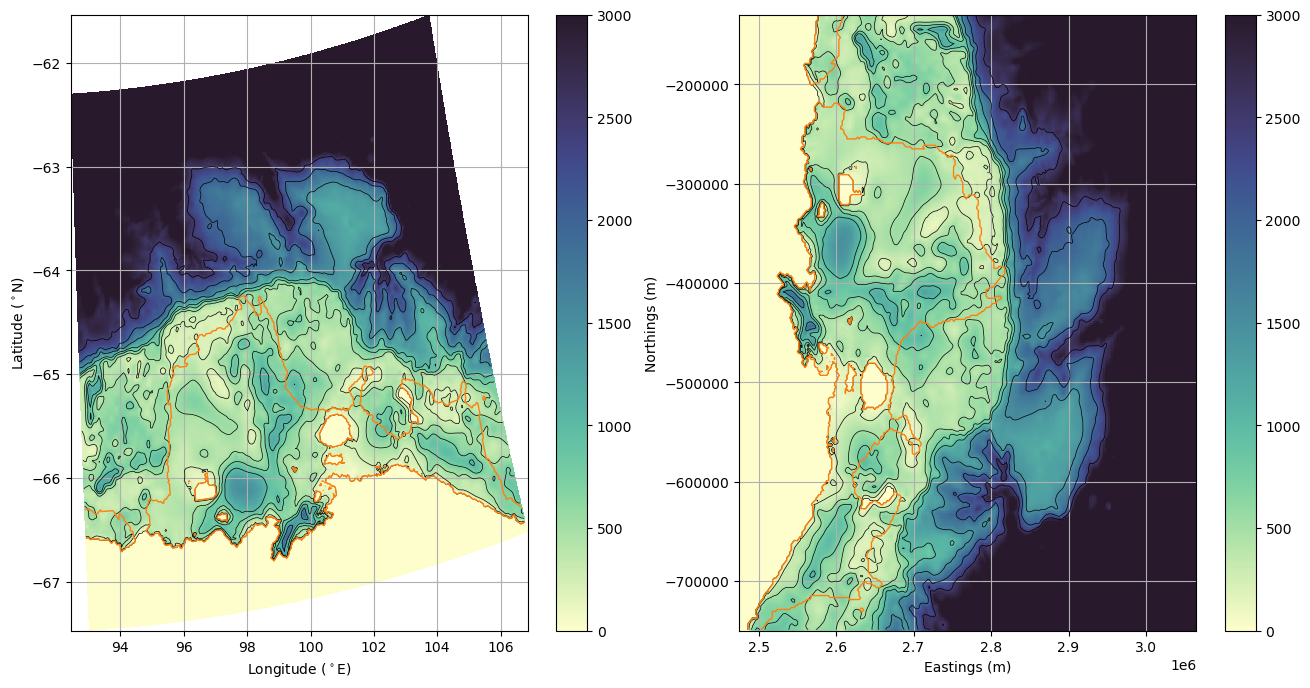

In [49]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[16,8])
ax = None


ax = fig.add_subplot(gs[0,0])

(ds_shackleton.h*ds_shackleton.mask_rho).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
(ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.5,levels=[0,250,500,750,1000,1500,2000,2500])
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='lon_rho',y='lat_rho',colors='C1',linestyles='-',linewidths=1,levels=(-1,0))

ax.set_xlabel(r'Longitude ($^\circ$E)')
ax.set_ylabel(r'Latitude ($^\circ$N)')
ax.grid()

ax = fig.add_subplot(gs[0,1])

(ds_shackleton.h*ds_shackleton.mask_rho).plot(x='x_rho',y='y_rho',cmap='cmo.deep')
(ds_shackleton.h*ds_shackleton.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='k',linewidths=0.5,levels=[0,250,500,750,1000,1500,2000,2500])
(ds_shackleton.zice*ds_shackleton.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='C1',linestyles='-',linewidths=1,levels=(-1,0))

ax.set_xlabel(r'Eastings (m)')
ax.set_ylabel(r'Northings (m)')
ax.grid()

Now let's extract some time series at a single point. We have to first define a function to extract the nearest point.

In [11]:

def extract_closest_ROMS(lon_target,lat_target,lon_field,lat_field):

    lat_diffs = np.abs(lat_field - lat_target)
    lon_diffs = np.abs(lon_field - lon_target)

    pyth_dist = (lat_diffs**2+lon_diffs**2)**0.5

    where = np.where(pyth_dist == pyth_dist.min())
    where_xi = where[1]
    where_eta = where[0]
    print('selected (xi,eta) at: (',where_xi,where_eta,') with lon/lat at: (',lon_field.isel(xi_rho=where_xi,eta_rho=where_eta).values,lat_field.isel(xi_rho=where_xi,eta_rho=where_eta).values,')')
    return where_xi,where_eta



Now choose an example location and let's plot some time series

In [12]:
lat_where = -65
lon_where = 100

where_xi,where_eta = extract_closest_ROMS(lon_where,lat_where,ds_shackleton.lon_rho,ds_shackleton.lat_rho)

selected (xi,eta) at: ( [120] [135] ) with lon/lat at: ( [[100.00196246]] [[-65.00515558]] )


Text(0.5, 0.98, 'Timeseries at 100.0,-65.0 at depth: 3.3 m')

<Figure size 640x480 with 0 Axes>

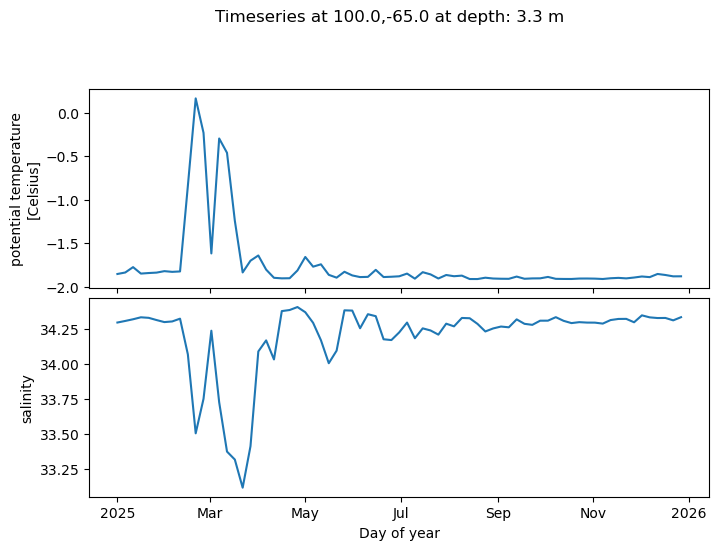

In [13]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,8])
ax = None


ax = fig.add_subplot(gs[0,0])
ds_shackleton.temp.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=-1).plot()
ax.set_xlabel('')
ax.set_title('')

ax = fig.add_subplot(gs[1,0])
ds_shackleton.salt.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=-1).plot()
ax.set_title('')

# ax = fig.add_subplot(gs[2,0])
# ds_shackleton.u.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=0).plot()

ax.set_xlabel('Day of year')

where_is_depth=ds_shackleton.z_rho0.isel(xi_rho=where_xi,eta_rho=where_eta).isel(s_rho=-1).values.round(1)[0][0]
where_is_lon=ds_shackleton.lon_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values.round(1)[0][0]
where_is_lat=ds_shackleton.lat_rho.isel(xi_rho=where_xi,eta_rho=where_eta).values.round(1)[0][0]

plt.suptitle('Timeseries at '+str(where_is_lon)+','+str(where_is_lat)+' at depth: '+str(-where_is_depth)+' m')

Plot multiple lines for multiple depths

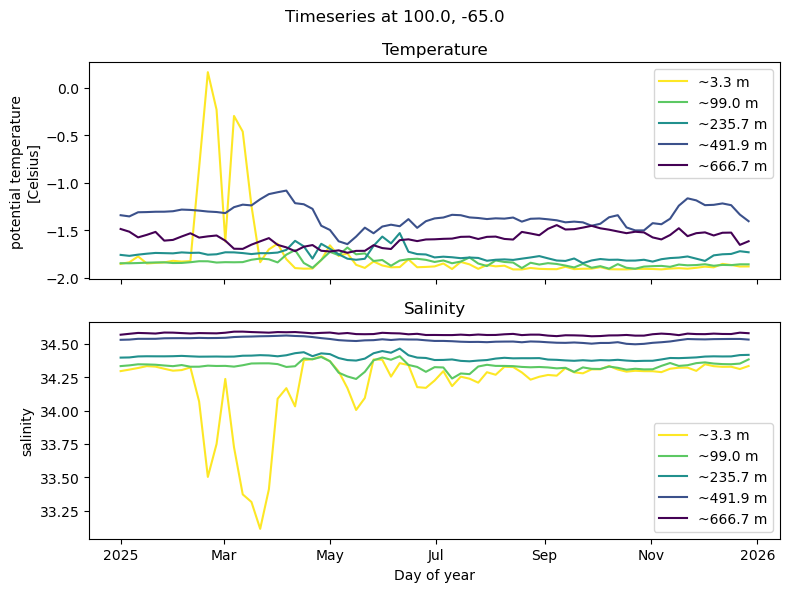

In [14]:
# Define target depths
which_depths = np.array([5, 100, 250, 500,1000])

# Get model depths at the selected location
z_levels = ds_shackleton.z_rho0.isel(xi_rho=where_xi, eta_rho=where_eta).values[:, 0][0]  # Extract the vertical profile
z_levels = -z_levels  # Convert to positive depths

# Find nearest depth indices
nearest_indices = [np.argmin(np.abs(z_levels - d)) for d in which_depths]

# Set up figure with 2 rows (temp, salinity)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)
colors = plt.cm.viridis_r(np.linspace(0, 1, len(which_depths)))  # Generate colors for each depth

# Plot temperature (row 1)
ax_temp = axes[0]
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.temp.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_temp, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_temp.set_title("Temperature")
ax_temp.set_xlabel("")
ax_temp.legend()

# Plot salinity (row 2)
ax_salt = axes[1]
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.salt.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_salt, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_salt.set_title("Salinity")
ax_salt.set_xlabel("Day of year")
ax_salt.legend()

# Add overall title
where_is_lon = ds_shackleton.lon_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
where_is_lat = ds_shackleton.lat_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
plt.suptitle(f'Timeseries at {where_is_lon}, {where_is_lat}')

plt.tight_layout()
plt.show()

Let's add current vectors, first we have to rotate them to the lat/lon grid

In [15]:

U = ds_shackleton.u + 1j*ds_shackleton.v
rotation_factor = np.exp(1j*ds_shackleton.angle)
rotated_velocity = U * rotation_factor
# Extract the real and imaginary parts (rotated u and v components)
u_lonlat = np.real(rotated_velocity)
v_lonlat = np.imag(rotated_velocity)

/tmp/ipykernel_31384/2523008048.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

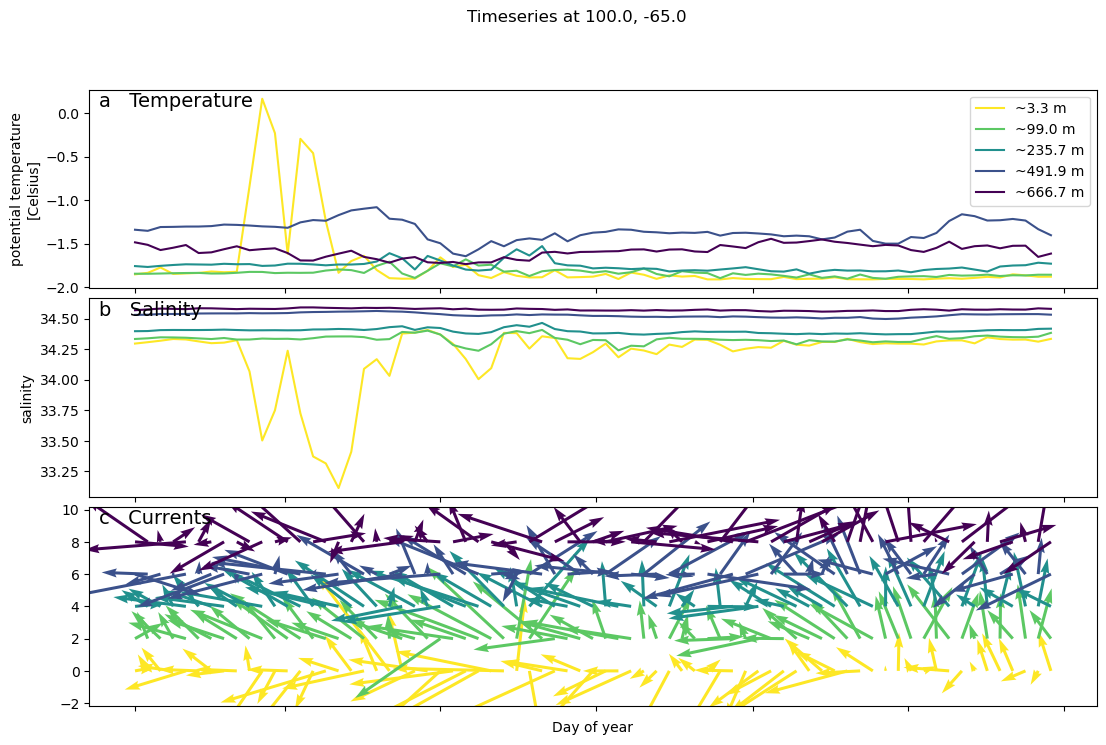

In [35]:
# Define target depths
which_depths = np.array([5, 100, 250, 500,1000])

# Get model depths at the selected location
z_levels = ds_shackleton.z_rho0.isel(xi_rho=where_xi, eta_rho=where_eta).values[:, 0][0]  # Extract the vertical profile
z_levels = -z_levels  # Convert to positive depths

# Find nearest depth indices
nearest_indices = [np.argmin(np.abs(z_levels - d)) for d in which_depths]


colors = plt.cm.viridis_r(np.linspace(0, 1, len(which_depths)))  # Generate colors for each depth


gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[13,8])
ax = None

# Plot temperature (row 1)
ax_temp = fig.add_subplot(gs[0,0])
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.temp.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_temp, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_temp.text(0.01,0.99,"a   Temperature", transform=ax_temp.transAxes,fontsize=14, va='top')
ax_temp.set_xlabel("")
ax_temp.legend()
ax_temp.set_title('')

# Plot salinity (row 2)
ax_salt = fig.add_subplot(gs[1,0])
for depth, idx, color in zip(which_depths, nearest_indices, colors):
    ds_shackleton.salt.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).plot(ax=ax_salt, color=color, label=f'~{z_levels[idx]:.1f} m')
ax_salt.text(0.01,0.99,"b   Salinity", transform=ax_salt.transAxes,fontsize=14, va='top')
ax_salt.set_title('')

# Plot currents (row 3)
ax_curr = fig.add_subplot(gs[2,0])
for depth, idx, color,y_pos in zip(which_depths, nearest_indices, colors,range(len(which_depths))):
    ax_curr.quiver(ds_shackleton.date.values,np.ones(len(ds_shackleton.date.values))*y_pos*2,
           u_lonlat.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).squeeze(),
           v_lonlat.isel(xi_rho=where_xi, eta_rho=where_eta, s_rho=idx).squeeze(), color=color, label=f'~{z_levels[idx]:.1f} m', width=0.003, headwidth=3)
ax_curr.text(0.01,0.99,"c   Currents", transform=ax_curr.transAxes,fontsize=14, va='top')
ax_curr.set_xlabel("Day of year")
# ax_curr.legend()
y_min, y_max = ax_curr.get_ylim()
y_range = y_max - y_min
new_y_min = y_min - 0.2 * y_range
new_y_max = y_max + 0.2 * y_range
ax_curr.set_ylim(new_y_min, new_y_max)
ax_curr.set_title('')
ax_curr.set_xticklabels([])

# Add overall title
where_is_lon = ds_shackleton.lon_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
where_is_lat = ds_shackleton.lat_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
plt.suptitle(f'Timeseries at {where_is_lon}, {where_is_lat}')

plt.tight_layout()
plt.show()

Now, make some vertical hovmoller plots for the same location.

/tmp/ipykernel_31384/667645348.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

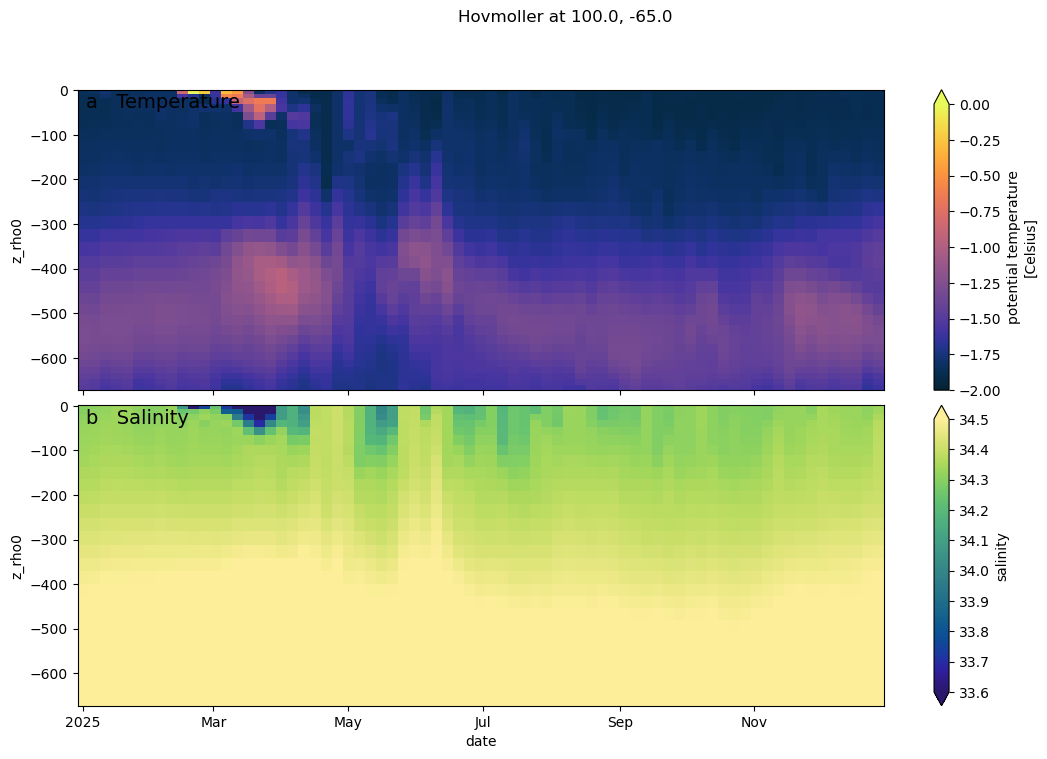

In [45]:

gs = gridspec.GridSpec(nrows=2,ncols=1,wspace=0.17, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[13,8])
ax = None

# Plot temperature (row 1)
ax_temp = fig.add_subplot(gs[0,0])
ds_shackleton.temp.isel(xi_rho=where_xi, eta_rho=where_eta).squeeze().T.plot(ax=ax_temp, y='z_rho0',cmap='cmo.thermal',vmin=-2,vmax=0)
ax_temp.text(0.01,0.99,"a   Temperature", transform=ax_temp.transAxes,fontsize=14, va='top')
ax_temp.set_xlabel("")
ax_temp.set_xticklabels([])
ax_temp.set_title('')

# Plot salinity (row 2)
ax_salt = fig.add_subplot(gs[1,0])
ds_shackleton.salt.isel(xi_rho=where_xi, eta_rho=where_eta).squeeze().T.plot(ax=ax_salt, y='z_rho0', cmap='cmo.haline',vmin=33.6,vmax=34.5)
ax_salt.text(0.01,0.99,"b   Salinity", transform=ax_salt.transAxes,fontsize=14, va='top')
ax_salt.set_title('')
ax_curr.set_xlabel("Day of year")


# Add overall title
where_is_lon = ds_shackleton.lon_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
where_is_lat = ds_shackleton.lat_rho.isel(xi_rho=where_xi, eta_rho=where_eta).values.round(1)[0][0]
plt.suptitle(f'Hovmoller at {where_is_lon}, {where_is_lat}')

plt.tight_layout()
plt.show()